In [1]:
!git clone https://github.com/schonkopf/soundscape_IR.git

fatal: destination path 'soundscape_IR' already exists and is not an empty directory.


In [ ]:
# pip install tensorflow-macos
# pip install keras

# Tool

In [20]:
import numpy as np
from soundscape_IR.soundscape_viewer import audio_visualization, spectrogram_detection, batch_processing, performance_evaluation, matrix_operation
from scipy.signal import butter, lfilter, gammatone
import librosa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, f1_score
from scipy.io import savemat
import os

class waveform_detection:
    def __init__(self, channel=1, offset_read=0, FFT_size=512, prewhiten_percent=0, bandpass_order=0, f_range=[0, 8000], downsample_sf=None, time_resolution=0.1, window_overlap=0):
        self.channel=channel
        self.offset_read=offset_read
        self.FFT_size=FFT_size
        self.prewhiten_percent=prewhiten_percent
        self.bandpass_order=bandpass_order
        self.f_range=f_range
        self.downsample_sf=downsample_sf
        self.time_resolution=time_resolution
        self.window_overlap=window_overlap
        self.detection_threshold = 0.5
        self.run_detection=False

    def collect_folder(self, folder, file_extension='.wav', annotation_folder=None, annotation_extension='.txt', status_print=True):
        if not annotation_folder:
            annotation_folder=folder
        annotation_file=None
        file_n=0

        # List audio files
        batch=batch_processing(folder=folder, file_extension='.wav')
        for filename in batch.audioname:
            if status_print:
                file_n=file_n+1
                print('\r', end='')
                print('Processing file no. '+str(file_n)+': '+filename, flush=True, end='')
            if annotation_extension:
                annotation_file=annotation_folder+filename[:-4]+annotation_extension
            # Generate samples
            x, y, timevec = self.load_waveform(folder, filename, annotation_file)
            if batch.audioname[0]==filename:
                X=x
                Y=y
            else:
                X=np.vstack((X,x))
                Y=np.append(Y,y)
        return X, Y

    def load_waveform(self, path, filename, annotation_file=None):
        # Load audio
        sound = audio_visualization(filename=filename, path=path, channel=self.channel, offset_read=self.offset_read, FFT_size=self.FFT_size, prewhiten_percent=self.prewhiten_percent, plot_type=None)
        # Spectrogram prewhitening and waveform reconstruction
        if self.prewhiten_percent>0:
            sound.convert_audio(sound.data, snr_factor=1.5)
            sound.x=sound.xrec
        # Bandpass filtering
        if self.bandpass_order>0:
            low_cutoff = self.f_range[0]/(0.5*sound.sf)
            high_cutoff = self.f_range[1]/(0.5*sound.sf)
            if high_cutoff>=1:
                b, a = butter(self.bandpass_order, low_cutoff, btype='high')
            else:
                if low_cutoff==0:
                    b, a = butter(self.bandpass_order, high_cutoff, btype='low')
                else:
                    b, a = butter(self.bandpass_order, [low_cutoff, high_cutoff], btype='band')
            sound.x = lfilter(b, a, sound.x)
        # Waveform resampling
        if self.downsample_sf:
            sound.x = librosa.resample(sound.x, orig_sr=sound.sf, target_sr=self.downsample_sf)
            sound.sf=self.downsample_sf
            if self.f_range[1]>sound.sf/2:
                self.f_range[1]=sound.sf/2
        # Scale normalization
        sound.x=sound.x/np.mean(np.abs(sound.x))

        # Fragment audio
        fragment_length=int(sound.sf*self.time_resolution)
        hop_length = int(fragment_length*(1-self.window_overlap))
        X = librosa.util.frame(sound.x, frame_length=fragment_length, hop_length=hop_length)
        X = X.T
        timevec=np.arange(0,X.shape[0],1)*hop_length/sound.sf+self.offset_read
        #X=X/np.max(np.abs(X), axis=1, keepdims=True)

        # Load annotation
        if annotation_file:
            annotation=performance_evaluation(np.hstack((timevec[:,None], np.ones((timevec.shape[0],1)))), annotation_file, fpr_control=0, plot=False)
            Y=annotation.label
        else:
            Y=np.zeros(X.shape[0])

        return X, Y, timevec

    def generate_gammatone_filters(self, fs=12000, num_filters=16, filter_length=64):
        center_freqs = np.linspace(self.f_range[0], self.f_range[1], num_filters+1)[:-1]

        filters = []
        for fc in center_freqs:
            gt_filter, _ = gammatone(fc, ftype='fir', order=4, fs=fs, numtaps=filter_length)
            filters.append(gt_filter)
        filters = np.array(filters).reshape((filter_length, 1, num_filters))
        return filters

    def train_model(self, X, Y, model=None, epochs=5, batch_size=32, test_size=0.5, conv1d_init='gammatone', status_print=0):
        # Split training and testing datasets
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=40)
        input_shape = (X_train.shape[1], 1)

        X_train = X_train.reshape(-1, X_train.shape[1], 1)  # Reshape for Conv1D input
        X_test = X_test.reshape(-1, X_test.shape[1], 1)

        # Model initialization
        if not model:
            model = Sequential()

            if conv1d_init == 'gammatone':
                # Initialize the Conv1D layer without weights
                conv1 = Conv1D(16, kernel_size=64, activation='relu', input_shape=input_shape, trainable=False)
                model.add(conv1)  # Add the layer to the model to build it

                # Generate gammatone filters and set them after the layer has been added to the model
                gammatone_filters = self.generate_gammatone_filters(fs=int(self.downsample_sf), num_filters=16, filter_length=64)
                conv1.set_weights([gammatone_filters, np.zeros(16)])  # Set filters and biases
            else:
                # Add a standard Conv1D layer if not using gammatone initialization
                conv1 = Conv1D(16, kernel_size=64, activation='relu', input_shape=input_shape)
                model.add(conv1)

            # Continue adding other layers
            model.add(MaxPooling1D(pool_size=8))
            model.add(Conv1D(32, kernel_size=16, activation='relu'))
            model.add(MaxPooling1D(pool_size=8))
            model.add(Conv1D(64, kernel_size=4, activation='relu'))
            model.add(Flatten())
            model.add(Dense(64, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Dense(32, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Dense(1, activation='sigmoid'))  # Change to 'softmax' if you have multiple classes

            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Training
        history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), verbose=status_print)

        # Model evaluation
        prediction = model.predict(X_test, verbose=0)
        fpr, tpr, thresholds = roc_curve(Y_test, prediction)
        auc_score = auc(fpr, tpr)
        threshold = thresholds[(np.abs(fpr - 0.15)).argmin()]
        f1=f1_score(Y_test, prediction>threshold, average='binary')
        print('\r', end='')
        print(f'AUC score: {auc_score:.4f}, F1 score@ 15%FPR: {f1:.4f}')
        self.threshold=threshold

        return model

    def params_spectrogram_detection(self, threshold=0.1, minimum_interval=0, minimum_duration=0, detection_folder='./', detection_extension='_Detection.txt'):
        self.detection_threshold = threshold
        self.detection_minimum_interval = minimum_interval
        self.detection_minimum_duration = minimum_duration
        self.detection_folder = detection_folder
        self.detection_extension = detection_extension
        self.run_detection=True
    
    def batch_prediction(self, model, folder, file_extension='.wav', annotation_folder=None, annotation_extension='.txt', status_print=True):
        # Ensure detection folder exists
        if not os.path.exists(self.detection_folder):
            os.makedirs(self.detection_folder)

        # List audio files
        batch = batch_processing(folder=folder, file_extension=file_extension)
        file_n = 0
        for filename in batch.audioname:
            file_n += 1
            if status_print:
                print(f'\rProcessing file no. {file_n}: {filename}', flush=True, end='')

            # Generate samples
            x, y, timevec = self.load_waveform(folder, filename)
            # Center the time vector focus
            timevec = timevec + self.time_resolution / 2
            # Pad with zeros if necessary
            if model.input_shape[1] - x.shape[1] > 0:
                x = np.pad(x, ((0, 0), (0, model.input_shape[1] - x.shape[1])), 'constant')

            # Run prediction
            prediction = model.predict(x, verbose=0)
            result = np.hstack((timevec[:, None], np.matlib.repmat(prediction, 1, 2)))

            # Run detection and save results
            if self.run_detection:
                detection_file = os.path.join(self.detection_folder, filename[:-4] + self.detection_extension)
                sp = spectrogram_detection(result, f=self.f_range, threshold=self.detection_threshold,
                                        minimum_interval=self.detection_minimum_interval, minimum_duration=self.detection_minimum_duration,
                                        filename=detection_file, show_result=False, status_print=False)
            print(f', Processed {filename}')


In [74]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram
import numpy as np
import matplotlib.patches as patches

def calculate_spectrogram(file_path, nperseg=4096, noverlap=0, prewhiten_percentile=5):
    sample_rate, data = wavfile.read(file_path)    
    if data.ndim == 2:
        data = data.mean(axis=1)

    prewhiten_value = np.percentile(data, prewhiten_percentile)
    data -= prewhiten_value
    frequencies, times, Sxx = spectrogram(data, sample_rate, nperseg=nperseg, noverlap=noverlap)
    return frequencies, times, Sxx

def plot_spectrogram1(frequencies, times, Sxx, detection_results=None, threshold=0.8, time_range=None, freq_range=None, xlim=None):
    plt.figure(figsize=(10, 5))

    # Determine the indices for time and frequency filtering
    time_indices = np.ones_like(times, dtype=bool)  # Initialize with all True
    freq_indices = np.ones_like(frequencies, dtype=bool)  # Initialize with all True

    # # Update time_indices based on detection results
    if detection_results is not None:
        # Filter times where detection probability exceeds the threshold
        high_prob_times = detection_results[:, 0][detection_results[:, 1] > threshold]
        # if high_prob_times.size > 0:
        #     time_indices &= (times >= high_prob_times.min()) & (times <= high_prob_times.max())

    # Update time_indices based on specified time_range
    if time_range is not None:
        time_indices &= (times >= time_range[0]) & (times <= time_range[1])

    # Update freq_indices based on specified freq_range
    if freq_range is not None:
        freq_indices &= (frequencies >= freq_range[0]) & (frequencies <= freq_range[1])

    # Apply filters to times, frequencies, and Sxx
    times = times[time_indices]
    frequencies = frequencies[freq_indices]
    Sxx = Sxx[freq_indices, :][:, time_indices]

    # Plot the filtered spectrogram
    extent = [times.min(), times.max(), frequencies.min(), frequencies.max()]
    plt.imshow(10 * np.log10(Sxx), aspect='auto', extent=extent, origin='lower', cmap='jet', interpolation='none')

    # Overlay detections on the spectrogram
    if detection_results is not None and high_prob_times.size > 0:
        freq_idx = np.argmin(np.abs(frequencies - np.mean(frequencies)))  # Example: plot at mean frequency
        plt.scatter(high_prob_times, [frequencies[freq_idx]] * len(high_prob_times), color='red', s=5, label='High Probability Detections')

    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    plt.title('Spectrogram with Detections')
    plt.colorbar(label='Intensity [dB]')
    plt.legend(frameon=False, loc=(1.05, -0.1))
    plt.show()

def extract_calls_fixed_duration(times, probabilities, threshold, fixed_duration, window_duration, max_duration):
    """
    Extract call intervals by merging consecutive windows above the threshold,
    enforcing a minimum duration and filtering out calls that are too long.
    
    Parameters:
        times: 1D array of window center times.
        probabilities: 1D array of detection probabilities corresponding to times.
        threshold: float, probability threshold for considering a window as containing a call.
        fixed_duration: float, the minimum duration (in seconds) for a call.
        window_duration: float, the duration of each analysis window.
        max_duration: float, the maximum allowed duration for a call (e.g. mean_duration * 1.3).
    
    Returns:
        call_intervals: list of tuples (start_time, end_time) in seconds for valid calls.
    """
    call_intervals = []
    in_call = False
    call_start_center = None  # store the center time when a call starts

    for t, prob in zip(times, probabilities):
        if prob >= threshold:
            if not in_call:
                in_call = True
                call_start_center = t
        else:
            if in_call:
                # We just finished a call segment.
                call_end_center = t
                # Convert center times to approximate boundaries:
                call_start_actual = call_start_center - (window_duration / 2)
                call_end_actual = call_end_center + (window_duration / 2)
                # Enforce the fixed (minimum) duration:
                if call_end_actual - call_start_actual < fixed_duration:
                    call_end_actual = call_start_actual + fixed_duration
                # Filter out calls that are too long:
                if (call_end_actual - call_start_actual) <= max_duration:
                    call_intervals.append((call_start_actual, call_end_actual))
                else:
                    # Optionally, you can log or handle the long call here.
                    pass
                in_call = False

    # If the last window was still above threshold, close the call using the last time.
    if in_call:
        call_end_center = times[-1]
        call_start_actual = call_start_center - (window_duration / 2)
        call_end_actual = call_end_center + (window_duration / 2)
        if call_end_actual - call_start_actual < fixed_duration:
            call_end_actual = call_start_actual + fixed_duration
        if (call_end_actual - call_start_actual) <= max_duration:
            call_intervals.append((call_start_actual, call_end_actual))
        # Otherwise, the call is too long and will be discarded.
        
    return call_intervals

def plot_spectrogram(frequencies, times, Sxx, filtered_call_intervals=None, low_freq=3000, high_freq=5000, freq_range=None, xlim=None, cmap='jet',
                     prewhitening_percentile=5, axis=1, figsize=None, title='Spectrogram with Detected Call Intervals'):
    if figsize is not None:
        plt.figure(figsize=(figsize[0], figsize[1]))
    else:
        plt.figure(figsize=(10, 5))
    if freq_range:
        freq_indices = (frequencies >= freq_range[0]) & (frequencies <= freq_range[1])
    else:
        freq_indices = (frequencies >= low_freq) & (frequencies <= high_freq)

    frequencies = frequencies[freq_indices]
    Sxx = Sxx[freq_indices, :]

    if prewhitening_percentile is not None:
        # Calculate the specified percentile across the specified axis
        ambient = np.percentile(Sxx, prewhitening_percentile, axis=axis)

        if axis == 0:
            Sxx = np.subtract(Sxx, np.matlib.repmat(ambient, Sxx.shape[axis], 1))
        elif axis == 1:
            Sxx = np.subtract(Sxx, np.matlib.repmat(ambient, Sxx.shape[axis], 1).T)

    extent = [times.min(), times.max(), frequencies.min(), frequencies.max()]
    plt.imshow(10 * np.log10(Sxx), aspect='auto', extent=extent, origin='lower', cmap=cmap, interpolation='none')
    if filtered_call_intervals is not None:
        box_low_freq = max(low_freq, freq_range[0] if freq_range else low_freq)
        box_high_freq = min(high_freq, freq_range[1] if freq_range else high_freq)
        for start, end in filtered_call_intervals:
            rect = patches.Rectangle((start, box_low_freq), end-start, box_high_freq-box_low_freq, linewidth=1, edgecolor='red', facecolor='none')
            plt.gca().add_patch(rect)

    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if title:
        plt.title(title)
    plt.colorbar(label='Intensity [dB]')
    plt.show()

def collect_wav_folder(path, file_extension):
    file_list=os.listdir(path)
    file_list.sort(key = str.lower)
    audioname=np.array([], dtype=object)
    for filename in file_list:
        if filename.endswith(file_extension):
            audioname = np.append(audioname, filename)
    print('Identified ', len(audioname), 'files')
    return audioname

# Model training

In [25]:
import warnings
warnings.filterwarnings('ignore')

import keras
keras.backend.clear_session()

In [1]:
import os
import pandas as pd

def summarise_labelled_txt(directory, extension='.txt', save_csv=False, output_filename="combined_selections.csv"):
    """
    Collects all text files in the given directory with the specified extension,
    combines them into one DataFrame, computes summary statistics, and optionally saves the combined DataFrame.
    
    Parameters:
        directory (str): Path to the directory containing the .txt files.
        extension (str): File extension to look for. Default is '.txt'.
        save_csv (bool): If True, the combined DataFrame is saved as a CSV file.
        output_filename (str): Name of the CSV file to save if save_csv is True.
        
    Returns:
        combined_df (DataFrame): The concatenated DataFrame from all the .txt files.
        summary_stats (dict): A dictionary containing summary statistics.
    """
    
    # Collect a sorted list of full file paths for files with the specified extension.
    txt_files = sorted([os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(extension)])
    print(f"Found {len(txt_files)} labelled txt files in '{directory}'.")

    # Read each file into a DataFrame and collect them.
    df_list = []
    for file in txt_files:
        try:
            df = pd.read_csv(file, sep='\t')
            df_list.append(df)
        except Exception as e:
            print(f"Error reading {file}: {e}")
    
    if not df_list:
        raise ValueError("No valid files found to combine.")
    
    # Combine all DataFrames.
    combined_df = pd.concat(df_list, ignore_index=True)
    
    # Compute the number of rows.
    num_rows = combined_df.shape[0]
    print("Total number of labelled calls:", num_rows)
    
    # Compute 'Delta Time (s)' if the required columns exist.
    if 'Begin Time (s)' in combined_df.columns and 'End Time (s)' in combined_df.columns:
        combined_df['Delta Time (s)'] = combined_df['End Time (s)'] - combined_df['Begin Time (s)']
    else:
        print("Columns 'Begin Time (s)' and/or 'End Time (s)' not found in the DataFrame.")
    
    # Calculate summary statistics.
    summary_stats = {}
    if 'Delta Time (s)' in combined_df.columns:
        summary_stats['median_duration'] = round(combined_df['Delta Time (s)'].median(), 2)
        summary_stats['min_duration'] = round(combined_df['Delta Time (s)'].min(), 2)
        summary_stats['max_duration'] = round(combined_df['Delta Time (s)'].max(), 2)
    if 'Low Freq (Hz)' in combined_df.columns:
        summary_stats['low_freq'] = round(combined_df['Low Freq (Hz)'].min(), 0)
    if 'High Freq (Hz)' in combined_df.columns:
        summary_stats['high_freq'] = round(combined_df['High Freq (Hz)'].max(), 0)
    
    
    # Print summary statistics.
    print("Summary Statistics:")
    for key, value in summary_stats.items():
        print(f"  {key}: {value}")
    
    # Optionally save the combined DataFrame to CSV.
    if save_csv:
        output_path = os.path.join(directory, output_filename)
        combined_df.to_csv(output_path, index=False)
        print(f"Combined DataFrame saved to: {output_path}")
    
    return combined_df, summary_stats

directory = 'Audio/HK-BlueWhistlingThrush/'  # Change this to your directory
combined_df, stats = summarise_labelled_txt(directory, extension='.txt', save_csv=False)


Found 3 labelled txt files in 'Audio/HK-BlueWhistlingThrush/'.
Total number of labelled calls: 122
Summary Statistics:
  median_duration: 1.07
  min_duration: 0.53
  max_duration: 1.92
  low_freq: 5435.0
  high_freq: 7026.0


In [90]:
path='Audio/HK-BlueWhistlingThrush/'
low_freq = 5400
high_freq = 7100
median_duration = 1.07
click=waveform_detection(channel=1, offset_read=0, FFT_size=4096,
                prewhiten_percent=0, bandpass_order=3, f_range=[low_freq, high_freq], downsample_sf=96000,
                time_resolution=1, window_overlap=0.5)
X, Y = click.collect_folder(folder=path, file_extension='.wav', annotation_folder=path, annotation_extension='.Table.1.selections.txt', status_print=True)
print('\t ##### \t')
model=click.train_model(X, Y, model=None, epochs=20, batch_size=64, test_size=0.2, conv1d_init='gammatone')

Identified  3 files
Processing file no. 3: S4A01321_20180809_163000.wav	 ##### 	
AUC score: 0.8654, F1 score@ 15%FPR: 0.6456


In [91]:
model.save('Audio/HK-BlueWhistlingThrush/BlueWhistlingThrush.keras')

# Run prediction on single file

In [92]:
import keras
keras.backend.clear_session()
model = keras.saving.load_model('Audio/HK-BlueWhistlingThrush/BlueWhistlingThrush.keras')

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


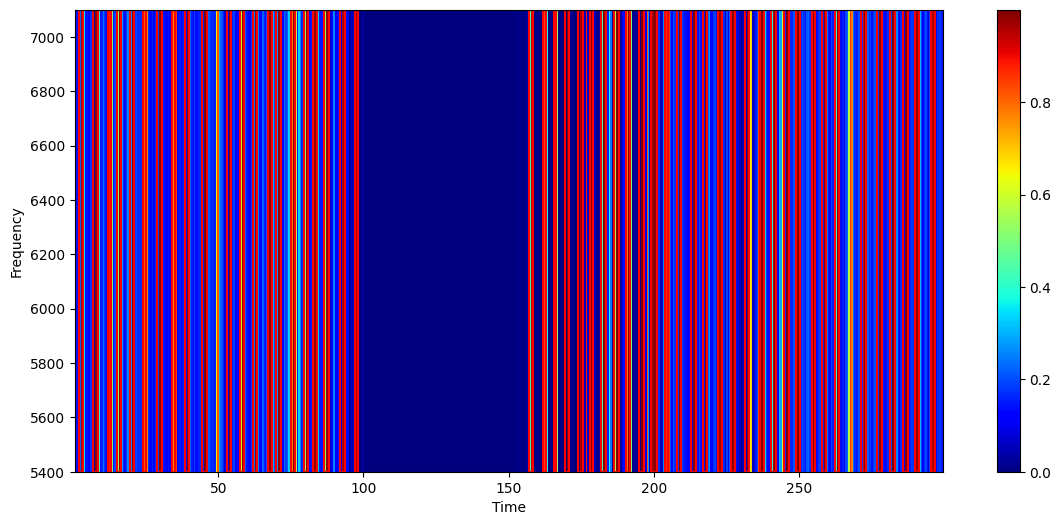

In [93]:
import numpy as np

path='Audio/HK-BlueWhistlingThrush/'
filename='S4A01321_20180809_163000.wav'
annotation=filename[:-4]+'.Table.1.selections.txt'

# Initialize the waveform detection instance
click=waveform_detection(channel=1, offset_read=0, FFT_size=4096,
                         prewhiten_percent=0, bandpass_order=3, f_range=[low_freq, high_freq], downsample_sf=96000,
                         time_resolution=1, window_overlap=0.5)
x, y, timevec = click.load_waveform(path, filename, path+annotation)
timevec = timevec + click.time_resolution / 2  # Center the time vector

input_length = model.input_shape[1] 
# Check if padding is needed
if input_length - x.shape[1] > 0:
    x = np.pad(x, ((0, 0), (0, input_length - x.shape[1])), 'constant')

# Run prediction
prediction = model.predict(x)
result = np.hstack((timevec[:, None], np.matlib.repmat(prediction, 1, 2)))

# Run detection
sp = spectrogram_detection(result, f=[low_freq, high_freq], threshold=0.9, minimum_interval=0.1, filename='S4A01321_20180809_173000.Table.1.selections.txt', show_result=True, status_print=False)

In [94]:
path='Audio/HK-BlueWhistlingThrush/'
filename='S4A01321_20180809_163000.wav'

audio_path = path + filename
freq, times, sxx = calculate_spectrogram(audio_path, nperseg=4096, noverlap=0, prewhiten_percentile=5)
# plot_spectrogram(freq, times, sxx, detection_results=result, threshold=0.8, time_range=None, freq_range=[0, 10000], xlim=[152, 165]) #
max_dur = 3
filtered_call_intervals = extract_calls_fixed_duration(
    times=result[:,0],
    probabilities=result[:,1],
    threshold=0.9,
    fixed_duration=median_duration,  # or any fixed duration you desire
    window_duration=click.time_resolution,  # e.g. 1 second
    max_duration=max_dur
)
print("Detected call intervals:", len(filtered_call_intervals), 'calls')
for start, end in filtered_call_intervals:
    print(f"Start: {start:.2f} s, End: {end:.2f} s")

Detected call intervals: 52 calls
Start: 2.00 s, End: 4.00 s
Start: 7.00 s, End: 9.00 s
Start: 12.00 s, End: 13.50 s
Start: 15.00 s, End: 17.00 s
Start: 19.50 s, End: 21.50 s
Start: 24.00 s, End: 25.50 s
Start: 29.00 s, End: 31.00 s
Start: 34.00 s, End: 35.50 s
Start: 38.50 s, End: 40.50 s
Start: 44.50 s, End: 46.50 s
Start: 53.00 s, End: 55.00 s
Start: 57.50 s, End: 59.50 s
Start: 62.00 s, End: 64.00 s
Start: 67.00 s, End: 69.00 s
Start: 70.00 s, End: 72.00 s
Start: 75.00 s, End: 77.00 s
Start: 79.50 s, End: 81.50 s
Start: 82.50 s, End: 84.50 s
Start: 86.50 s, End: 88.50 s
Start: 92.00 s, End: 94.00 s
Start: 97.00 s, End: 98.50 s
Start: 157.00 s, End: 159.00 s
Start: 162.00 s, End: 163.50 s
Start: 165.50 s, End: 167.00 s
Start: 169.50 s, End: 171.50 s
Start: 174.00 s, End: 176.00 s
Start: 178.00 s, End: 179.50 s
Start: 182.00 s, End: 184.00 s
Start: 186.50 s, End: 188.50 s
Start: 190.50 s, End: 192.50 s
Start: 195.00 s, End: 197.00 s
Start: 199.00 s, End: 201.50 s
Start: 204.00 s, End

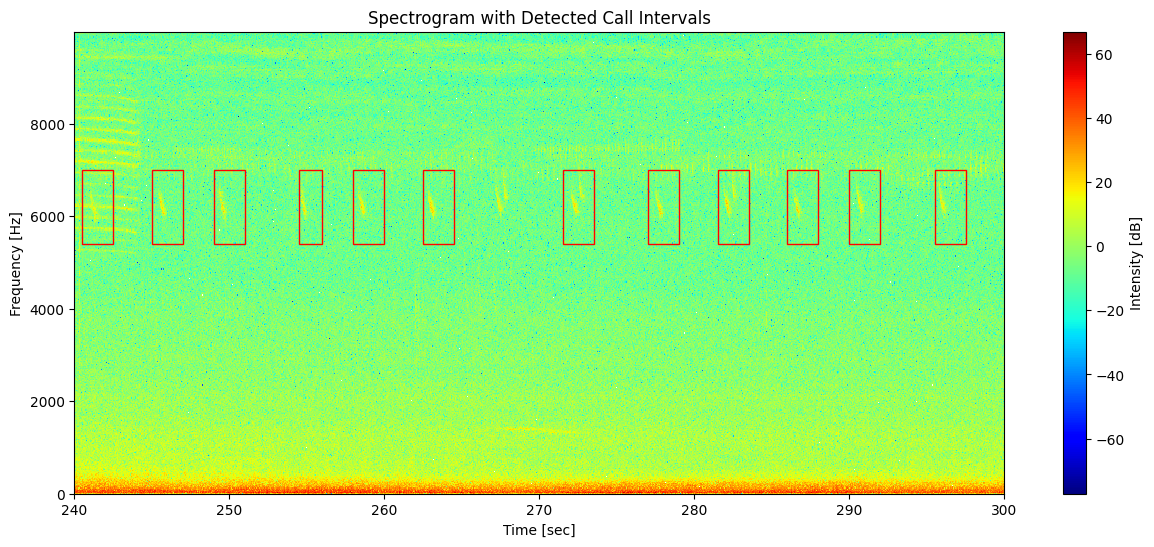

In [98]:
low_freq = 5400
high_freq = 7000
plot_spectrogram(freq, times, sxx, filtered_call_intervals=filtered_call_intervals, xlim=[240, 300], 
                 low_freq=low_freq, high_freq=high_freq, freq_range=[0, 10000], figsize=[15,6], prewhitening_percentile=0)

# Model prediction

In [147]:
import keras
keras.backend.clear_session()
model = keras.saving.load_model('Audio/HK-bird2/LFS_bird.keras')

ctb = keras.saving.load_model('Bird-models/CommonTailorbird.keras')
bird_un = keras.saving.load_model('Bird-models/Bird_unknown.keras')
crow =  keras.saving.load_model('Bird-models/Crow.keras')
bw_thurs = keras.saving.load_model('Bird-models/Crow.keras')

In [ ]:
path='/Volumes/Derek/Research/Data/Acoustics/HK-LFS-20180807-20180821-SM4/HK-LFS-20180807-20180821-SM4-wav/'

click=waveform_detection(channel=1, offset_read=0, FFT_size=512,
                prewhiten_percent=0, bandpass_order=3, f_range=[low_freq, high_freq], downsample_sf=96000,
                time_resolution=0.002, window_overlap=0.5)
click.params_spectrogram_detection(threshold=0.8, minimum_interval=0.002, detection_folder='./LFS_Detection/', detection_extension='_Detection.txt')
click.batch_prediction(model, path, file_extension='.wav', annotation_folder=None, annotation_extension='.txt', status_print=True)

threshold, fpr, tpr=click.performance.auc(click.label, click.level, fpr_control=0.05, plot=True)

In [250]:
import time
start_time = time.time() 

path='/Users/hoyuenwa/Documents/Python Projects/CNN1D-click/Audio/LFS_bird1_test/'
click = waveform_detection(channel=1, offset_read=0, FFT_size=512,
                           prewhiten_percent=0, bandpass_order=3, f_range=[3300, 5100], downsample_sf=96000,
                           time_resolution=0.005, window_overlap=0.5)
click.params_spectrogram_detection(threshold=0.8, minimum_interval=0.005, detection_folder='./Detection/', detection_extension='_Detection.txt')
# path = '/Volumes/Extreme SSD/Research/PAM/LFS/'
click.batch_prediction(model, path, file_extension='.wav', status_print=True)

end_time = time.time()
print(f'Processed all files in {end_time - start_time:.2f} seconds.')

Identified  1 files
Processing file no. 1: S4A01321_20180808_063000.wav, Processed S4A01321_20180808_063000.wav
Processed all files in 8.82 seconds.


In [ ]:
import numpy as np

path='/Users/hoyuenwa/Documents/Python Projects/CNN1D-click/Audio/LFS_bird1_test/'
filename='S4A01321_20180808_063000.wav'
annotation=filename[:-4]+'.Table.1.selections.txt'

# Initialize the waveform detection instance
click=waveform_detection(channel=1, offset_read=0, FFT_size=512,
                         prewhiten_percent=0, bandpass_order=3, f_range=[3300, 5100], downsample_sf=96000,
                         time_resolution=0.01, window_overlap=0.8)
x, y, timevec = click.load_waveform(path, filename, path+annotation)
timevec = timevec + click.time_resolution / 2  # Center the time vector

input_length = model.input_shape[1] 

# Check if padding is needed
if input_length - x.shape[1] > 0:
    x = np.pad(x, ((0, 0), (0, input_length - x.shape[1])), 'constant')

# Run prediction
prediction = model.predict(x)
result = np.hstack((timevec[:, None], np.matlib.repmat(prediction, 1, 2)))

# Run detection
sp = spectrogram_detection(result, f=[3300, 5100], threshold=0.8, minimum_interval=0.005, filename='test2Detection.txt', show_result=False, status_print=False)

In [18]:
import pandas as pd

class batch_process:
    def __init__(self, path, model_directory, parameter_file):
        self.path = path
        self.model_directory = model_directory
        self.parameter_file = parameter_file
        self.models_params = {}

    def collect_wav_folder(self, file_extension='.wav'):
        return sorted([f for f in os.listdir(path) if f.endswith(file_extension)])

    def load_parameters(self):
        """
        Loads model parameters from a CSV file and initializes models.
        """
        # Clear previous Keras session
        keras.backend.clear_session()

        # Load parameters from CSV
        param_df = pd.read_csv(self.parameter_file)
        for _, row in param_df.iterrows():
            model_path = os.path.join(self.model_directory, row['model_file'])
            model = keras.models.load_model(model_path)
            self.models_params[row['model_name']] = {
                'model': model,
                'threshold': row['threshold'],
                'low_freq': row['low_freq'],
                'high_freq': row['high_freq'],
                'min_interval': row['min_interval'],
                'fixed_duration': row['fixed_duration'],
                'max_duration': row['max_duration']
            }
        print("Models loaded and parameters set from CSV.")

    # def batch_process_audio_multimodels(self, models_params):
    #     # Create an output folder for detections.
    #     detection_folder = os.path.join(path, 'Detection')
    #     if not os.path.exists(detection_folder):
    #         os.makedirs(detection_folder)
        
    #     # Get list of audio filenames.
    #     audionames = batch_process.collect_wav_folder(path=path, file_extension='.wav')
    #     print("Identified", len(audionames), "audio files")

    #     if not self.models_params:
    #         print("Model parameters are not loaded.")
    #         return
        
    #     # Process each audio file.
    #     for name in audionames:
    #         print("Processing file:", name)
            
    #         # Initialize waveform detection instance for this file.
    #         # Use default frequency parameters from the first model entry.
    #         default_low_freq = list(self.models_params.values())[0]['low_freq']
    #         default_high_freq = list(self.models_params.values())[0]['high_freq']
    #         click = waveform_detection(channel=1, offset_read=0, FFT_size=4096,
    #                                 prewhiten_percent=0, bandpass_order=3, 
    #                                 f_range=[default_low_freq, default_high_freq],
    #                                 downsample_sf=96000,
    #                                 time_resolution=1, window_overlap=0.5)
    #         x, y, timevec = click.load_waveform(path, name) # Load the waveform.
    #         timevec = timevec + click.time_resolution / 2 # Adjust time vector so it represents the centers.
            
    #         for model_name, params in self.models_params.items():
    #             species_detection_folder = os.path.join(detection_folder, model_name)
    #             if not os.path.exists(species_detection_folder):
    #                 os.makedirs(species_detection_folder)
                
    #             model = params['model']
    #             model_threshold = params['threshold']
    #             model_low_freq = params['low_freq']
    #             model_high_freq = params['high_freq']
    #             model_min_interval = params['min_interval']
    #             fixed_duration = params['fixed_duration']
    #             max_duration = params['max_duration']
                
    #             print("   Running model:", model_name)
    #             x_model = np.copy(x)
    #             input_length = model.input_shape[1]
    #             if input_length - x_model.shape[1] > 0:
    #                 x_model = np.pad(x_model, ((0, 0), (0, input_length - x_model.shape[1])), 'constant')
                
    #             prediction = model.predict(x_model)
    #             result = np.hstack((timevec[:, None], np.matlib.repmat(prediction, 1, 2)))
    #             save_result = result[result[:, 1] > model_threshold] # Save raw detection probabilities where probability exceeds the model-specific threshold.
    #             prob_filename = os.path.join(species_detection_folder, f"{name[:-4]}_{model_name}.DetProb.txt")
    #             pd.DataFrame(save_result).to_csv(prob_filename, index=False)
                
    #             # Now, extract calls using our fixed-duration extraction function.
    #             # This function will merge consecutive windows above threshold,
    #             # enforce a minimum duration (fixed_duration) and filter out calls that are too long.
    #             call_intervals = extract_calls_fixed_duration(
    #                 times=result[:, 0],
    #                 probabilities=result[:, 1],
    #                 threshold=model_threshold,
    #                 fixed_duration=fixed_duration,
    #                 window_duration=click.time_resolution,
    #                 max_duration=max_duration
    #             )
                
    #             # Save the extracted call intervals.
    #             detection_filename = os.path.join(species_detection_folder, f"{name[:-4]}_{model_name}.Detection.txt")
    #             with open(detection_filename, 'w') as f:
    #                 f.write("Start Time (s)\tEnd Time (s)\n")
    #                 for start, end in call_intervals:
    #                     f.write(f"{start:.2f}\t{end:.2f}\n")
                
    #             print(f"   Finished processing with model {model_name} for file {name}")

    def batch_process_audio_multimodels(self):
        """
        Batch processes audio files using multiple models with model-specific parameters stored in self.models_params.
        """
        detection_folder = os.path.join(self.path, 'Detection')
        if not os.path.exists(detection_folder):
            os.makedirs(detection_folder)
        
        audionames = self.collect_wav_folder(file_extension='.wav')
        print("Identified", len(audionames), "audio files")

        if not self.models_params:
            raise ValueError("Model parameters are not loaded. Please load parameters before processing.")

        for name in audionames:
            print("Processing file:", name)
            # Assuming waveform_detection and other methods are defined or correctly imported
            default_params = next(iter(self.models_params.values()))
            click = waveform_detection(channel=1, offset_read=0, FFT_size=4096,
                                    prewhiten_percent=0, bandpass_order=3,
                                    f_range=[default_params['low_freq'], default_params['high_freq']],
                                    downsample_sf=96000, time_resolution=1, window_overlap=0.5)
            x, y, timevec = click.load_waveform(self.path, name)
            timevec += click.time_resolution / 2  # Adjust time vector so it represents the centers.

            for model_name, params in self.models_params.items():
                species_detection_folder = os.path.join(detection_folder, model_name)
                if not os.path.exists(species_detection_folder):
                    os.makedirs(species_detection_folder)
                
                model = params['model']
                input_length = model.input_shape[1]
                x_model = np.pad(x, ((0, 0), (0, max(0, input_length - x.shape[1]))), 'constant')
                prediction = model.predict(x_model[np.newaxis, ...])
                result = np.hstack((timevec[:, None], prediction))
                
                # Extract and save calls based on model predictions
                # Implement or adjust call extraction logic accordingly

                print(f"Finished processing with model {model_name} for file {name}")


In [ ]:
if __name__ == "__main__":
    path = '/Volumes/Derek/Research/Data/Acoustics/HK-LFS-20180807-20180821-SM4/HK-LFS-20180807-20180821-SM4-wav/test/'
    model_directory = 'Bird-models/'
    parameter_file = 'Bird-models/model_parameters.csv'

    processor = batch_process(path, model_directory, parameter_file)
    processor.load_parameters()
    processor.batch_process_audio_multimodels()

In [ ]:
def collect_wav_folder(path=path, file_extension='.wav'):
        return sorted([f for f in os.listdir(path) if f.endswith(file_extension)])

def batch_process_audio_multimodels(models_params, path=path):
    # Create an output folder for detections.
    detection_folder = os.path.join(path, 'Detection')
    if not os.path.exists(detection_folder):
        os.makedirs(detection_folder)
    
    # Get list of audio filenames.
    audionames = collect_wav_folder(path=path, file_extension='.wav')
    print("Identified", len(audionames), "audio files")

    # Process each audio file.
    for name in audionames:
        print("Processing file:", name)
        
        # Initialize waveform detection instance for this file.
        # Use default frequency parameters from the first model entry.
        default_low_freq = list(models_params.values())[0]['low_freq']
        default_high_freq = list(models_params.values())[0]['high_freq']
        click = waveform_detection(channel=1, offset_read=0, FFT_size=4096,
                                prewhiten_percent=0, bandpass_order=3, 
                                f_range=[default_low_freq, default_high_freq],
                                downsample_sf=96000,
                                time_resolution=1, window_overlap=0.5)
        x, y, timevec = click.load_waveform(path, name) # Load the waveform.
        timevec = timevec + click.time_resolution / 2 # Adjust time vector so it represents the centers.
        
        for model_name, params in models_params.items():
            species_detection_folder = os.path.join(detection_folder, model_name)
            if not os.path.exists(species_detection_folder):
                os.makedirs(species_detection_folder)
            
            model = params['model']
            model_threshold = params['threshold']
            model_low_freq = params['low_freq']
            model_high_freq = params['high_freq']
            model_min_interval = params['min_interval']
            fixed_duration = params['fixed_duration']
            max_duration = params['max_duration']
            
            print("   Running model:", model_name)
            x_model = np.copy(x)
            input_length = model.input_shape[1]
            if input_length - x_model.shape[1] > 0:
                x_model = np.pad(x_model, ((0, 0), (0, input_length - x_model.shape[1])), 'constant')
            
            prediction = model.predict(x_model)
            result = np.hstack((timevec[:, None], np.matlib.repmat(prediction, 1, 2)))
            save_result = result[result[:, 1] > model_threshold] # Save raw detection probabilities where probability exceeds the model-specific threshold.
            prob_filename = os.path.join(species_detection_folder, f"{name[:-4]}_{model_name}.DetProb.txt")
            pd.DataFrame(save_result).to_csv(prob_filename, index=False)
            
            # Now, extract calls using our fixed-duration extraction function.
            # This function will merge consecutive windows above threshold,
            # enforce a minimum duration (fixed_duration) and filter out calls that are too long.
            call_intervals = extract_calls_fixed_duration(
                times=result[:, 0],
                probabilities=result[:, 1],
                threshold=model_threshold,
                fixed_duration=fixed_duration,
                window_duration=click.time_resolution,
                max_duration=max_duration
            )
            
            # Save the extracted call intervals.
            detection_filename = os.path.join(species_detection_folder, f"{name[:-4]}_{model_name}.Detection.txt")
            with open(detection_filename, 'w') as f:
                f.write("Start Time (s)\tEnd Time (s)\n")
                for start, end in call_intervals:
                    f.write(f"{start:.2f}\t{end:.2f}\n")
            
            print(f"   Finished processing with model {model_name} for file {name}")


if __name__ == "__main__":
    import keras     
    keras.backend.clear_session() # Clear previous Keras session.
    
    # Load models
    ctb = keras.saving.load_model('Bird-models/CommonTailorbird.keras')
    bird_un = keras.saving.load_model('Bird-models/Bird_unknown.keras')
    crow =  keras.saving.load_model('Bird-models/Crow.keras')
    bw_thrush = keras.saving.load_model('Bird-models/BlueWhistlingThrush.keras')
    
    # Model-specific parameters.
    models_params = {
        # 'CommonTailorbird': {
        #     'model': ctb,
        #     'threshold': 0.3,
        #     'low_freq': 2200,
        #     'high_freq': 6000,
        #     'min_interval': 0.1
        # },
        # 'BirdUnknown': {
        #     'model': bird_un,
        #     'threshold': 0.1,
        #     'low_freq': 3040,
        #     'high_freq': 9300,
        #     'min_interval': 0.1
        # }
        # 'Crow': {
        #     'model': crow,
        #     'threshold': 0.1,
        #     'low_freq': 600,
        #     'high_freq': 2200,
        #     'min_interval': 0.1
        # }
        'BlueWhistleThrust': {
            'model': bw_thrush,
            'threshold': 0.5,
            'low_freq': 5400,
            'high_freq': 7100,
            'min_interval': 0.15,
            'fixed_duration': 1,
            'max_duration': 3
        }
    }

    # Set the path for audio folder
    path = '/Volumes/Derek/Research/Data/Acoustics/HK-LFS-20180807-20180821-SM4/HK-LFS-20180807-20180821-SM4-wav/test/'
    batch_process_audio_multimodels(models_params=models_params, path=path)

In [ ]:
## Batch Process
path='/Volumes/Derek/Research/Data/Acoustics/HK-LFS-20180807-20180821-SM4/HK-LFS-20180807-20180821-SM4-wav/'
audioname = collect_wav_folder(path=path, file_extension='.wav')

for name in audioname:
    click=waveform_detection(channel=1, offset_read=0, FFT_size=4096,
                         prewhiten_percent=0, bandpass_order=3, f_range=[low_freq, high_freq], downsample_sf=96000,
                         time_resolution=1, window_overlap=0.5)
    x, y, timevec = click.load_waveform(path, name)
    timevec = timevec + click.time_resolution / 2  # Center the time vector

    input_length = model.input_shape[1] 
    if input_length - x.shape[1] > 0:
        x = np.pad(x, ((0, 0), (0, input_length - x.shape[1])), 'constant')

    # Run prediction
    prediction = model.predict(x)
    result = np.hstack((timevec[:, None], np.matlib.repmat(prediction, 1, 2)))
    save_result = result[result[:,1]>0.2]
    annotation_prob = path + 'Detection2/' + name[:-4]+'.DetProb.txt'
    pd.DataFrame(save_result).to_csv(annotation_prob)
    annotation= 'Detection2/' + name[:-4]+'.Detection.txt'
    sp = spectrogram_detection(result, f=[low_freq, high_freq], threshold=0.0, minimum_interval=0.1, filename=annotation, show_result=False, status_print=True)

In [ ]:
path='/Volumes/Extreme SSD/Research/PAM/LFS/'
filename='S4A01321_20180808_073000.wav'

audio_path = path + filename
freq, times, sxx = calculate_spectrogram(audio_path, nperseg=4096, noverlap=0, prewhiten_percentile=5)

In [40]:
prob_path = path + 'Detection/' + filename[:-4] + '.DetProb.txt'
result = np.loadtxt(prob_path, delimiter=',', skiprows=1, usecols=range(1, 4))
filtered_call_intervals = extract_calls_fixed_duration(result[:,0], result[:,1], threshold=0.9, mean_duration=0.19)
print("Detected call intervals:")
for start, end in filtered_call_intervals[0:5]:
    print(f"Start: {start:.2f} s, End: {end:.2f} s")

Detected call intervals:
Start: 165.32 s, End: 165.51 s
Start: 165.51 s, End: 165.70 s
Start: 165.72 s, End: 165.91 s
Start: 165.92 s, End: 166.11 s
Start: 166.11 s, End: 166.30 s


/var/folders/j4/3gpdgvn54ts8s2nb5sm3wlx40000gn/T/ipykernel_3153/3524855384.py:102: RuntimeWarning: invalid value encountered in log10
  plt.imshow(10 * np.log10(Sxx), aspect='auto', extent=extent, origin='lower', cmap=cmap, interpolation='none')


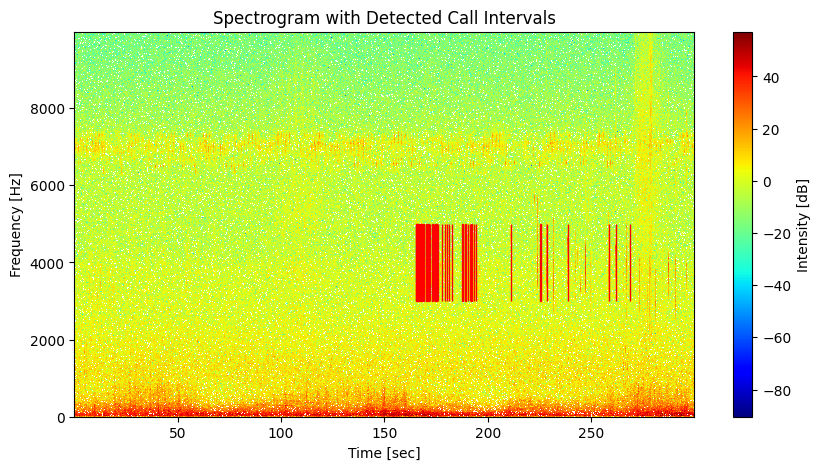

In [41]:
plot_spectrogram(freq, times, sxx, filtered_call_intervals=filtered_call_intervals, xlim=None, freq_range=[0, 10000], prewhitening_percentile=5)

/var/folders/j4/3gpdgvn54ts8s2nb5sm3wlx40000gn/T/ipykernel_3153/3524855384.py:102: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(10 * np.log10(Sxx), aspect='auto', extent=extent, origin='lower', cmap=cmap, interpolation='none')


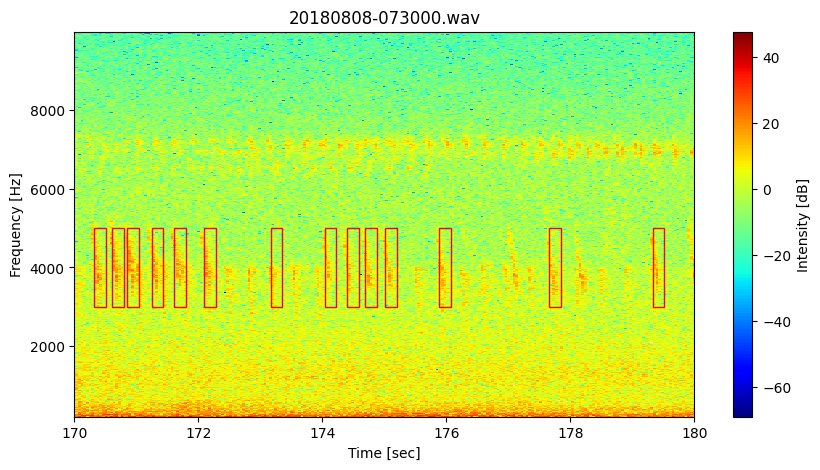

In [45]:
plot_spectrogram(freq, times, sxx, filtered_call_intervals=filtered_call_intervals, xlim=[170, 180], freq_range=[200, 10000], 
                 prewhitening_percentile=0, axis=1, cmap='jet',
                 title='20180808-073000.wav')

In [157]:
import numpy as np

def collect_detection_folder(path, file_extension):
    import os
    file_list=os.listdir(path)
    file_list.sort(key = str.lower)
    audioname=np.array([], dtype=object)
    for filename in file_list:
        if not filename.startswith('.') and filename.endswith(file_extension):
            audioname = np.append(audioname, filename)
    print('Identified ', len(audioname), 'files')
    return audioname

In [ ]:
detection_txt = collect_detection_folder(path='/Volumes/Derek/Research/Data/Acoustics/HK-LFS-20180807-20180821-SM4/HK-LFS-20180807-20180821-SM4-wav/Detection/', file_extension='.txt')

for txt in detection_txt:
    result = np.loadtxt(prob_path, delimiter=',', skiprows=1, usecols=range(1, 4))
    filtered_call_intervals = extract_calls_fixed_duration(result[:,0], result[:,1], threshold=0.95, mean_duration=0.19)    

In [ ]:
import os
import numpy as np
import pandas as pd
path='/Volumes/Derek/Research/Data/Acoustics/HK-LFS-20180807-20180821-SM4/HK-LFS-20180807-20180821-SM4-wav/test/Detection/'
detection_txt = collect_detection_folder(path='/Volumes/Derek/Research/Data/Acoustics/HK-LFS-20180807-20180821-SM4/HK-LFS-20180807-20180821-SM4-wav/test/Detection', file_extension='.txt')
final_df = pd.DataFrame()

for txt in detection_txt:
    result = np.loadtxt(path+txt, delimiter=',', skiprows=1)
    if result.size > 0:
        filtered_call_intervals = extract_calls_fixed_duration(result[:, 1], result[:, 2], threshold=0.95, mean_duration=0.19)
        temp_df = pd.DataFrame(filtered_call_intervals, columns=['Start', 'End'])
        filename = os.path.basename(txt)
        datetime_str = filename.split('_')[1] + '_' + filename.split('_')[2].replace('.DetProb.txt', '')
        datetime_obj = pd.to_datetime(datetime_str, format='%Y%m%d_%H%M%S')
        temp_df['Datetime'] = datetime_obj
        final_df = pd.concat([final_df, temp_df], ignore_index=True)
    else:
        pass

final_df# Ensure the Datetime column is set as the index
final_df.set_index('Datetime', inplace=True)

In [86]:
resampled_df = final_df.resample('30T').size()
resampled_df = resampled_df.to_frame(name='Count')
resampled_df.reset_index(inplace=True)
resampled_df.head(5)

,Datetime,Count
0,2018-08-08 05:00:00,1
1,2018-08-08 05:30:00,0
2,2018-08-08 06:00:00,8
3,2018-08-08 06:30:00,7
4,2018-08-08 07:00:00,3


In [88]:
import plotly.express as px
fig = px.line(x=resampled_df['Datetime'],y=resampled_df['Count'], markers=True)
fig.show()

In [220]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors
from suntime import Sun
from datetime import date, datetime, timedelta

class result_visualisation:
    def load_data(directory, end_str = '.DetProb.txt'):
        data_frames = []
        for file in os.listdir(directory):
            if file.endswith(end_str):
                file_path = os.path.join(directory, file)
                data = pd.read_csv(file_path)
                date_str, time_str = file.split('_')[1:3]
                time_str = time_str.split('.')[0]
                data['Date'] = pd.to_datetime(date_str, format='%Y%m%d').date()
                data['Time'] = pd.to_datetime(time_str, format='%H%M%S').time()
                data_frames.append(data)

        final_df = pd.concat(data_frames, ignore_index=True)
        if end_str.endswith('.DetProb.txt'):
            final_df.columns = ['Seconds','Probability', 'Probability', 'Date', 'Time']
        elif end_str.endswith('.Detection.txt'):
            final_df.iloc[:, 0] = final_df.iloc[:, 0].astype(str)
            split_columns = final_df.iloc[:, 0].str.split("\t", expand=True)
            final_df['Seconds'] = split_columns[0]
            final_df['EndTime'] = split_columns[1]
            final_df = final_df.iloc[:, 1:]
        final_df = final_df.loc[:, ~final_df.columns.duplicated()]  # Drop duplicated columns
        if len(final_df.columns) == 5:
            final_df = final_df.reset_index()
        else:
            pass
        return final_df

    def resample_df(df, time_interval='30T'):
        df['datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
        df.set_index('datetime', inplace=True)
        df_resampled = df.resample(time_interval).count()
        df_resampled.reset_index(inplace=True)
        df_resampled['date'] = df_resampled['datetime'].dt.date
        df_resampled['time_category'] = df_resampled['datetime'].dt.time.astype(str)
        return df_resampled

    def plot_heatmap(df, sun_times = None, figsize=(12, 8), cmap='jet', annot=False, 
                                    rotation=45, every_nth=2, title=None):
        """
        Plots a heatmap from a DataFrame and overlays sunrise and sunset times.

        Parameters:
        - df: DataFrame to plot the heatmap. Must contain 'time_category', 'date', and 'Seconds' columns.
        - sun_times: DataFrame containing 'date', 'sunrise', and 'sunset' columns.
        - figsize: tuple of (width, height) for the figure size.
        - cmap: colormap for the heatmap.
        - annot: boolean to annotate cells.
        - rotation: degree of rotation for the x-tick labels.
        - every_nth: interval for y-axis labels, showing labels every nth hour.
        """
        if df['time_category'].dtype == object:
            df['time_category'] = pd.to_datetime(df['time_category'], format='%H:%M:%S').dt.time

        heatmap_data = df.pivot_table(index='time_category', columns='date', values='Seconds', aggfunc='sum', fill_value=0)
        heatmap_data = heatmap_data.sort_index()

        plt.figure(figsize=figsize)
        ax = sns.heatmap(heatmap_data, annot=annot, cmap=cmap, fmt='d')

        hours = [time.strftime('%H:%M') for time in heatmap_data.index]
        ticks = np.arange(len(hours)) + 0.5
        labels = [hours[i] if i % every_nth == 0 else '' for i in range(len(hours))]
        ax.set_yticks(ticks)
        ax.set_yticklabels(labels, rotation=0)
        
        ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha="right")

        plt.xlabel('Date')
        plt.ylabel('Time')
        if title:
            plt.title(title, fontsize=16, pad=10)

        if sun_times is not None:
            sun_times['Date'] = pd.to_datetime(sun_times['Date']).dt.date
            sun_times['sunrise'] = pd.to_datetime(sun_times['sunrise'], format='%H:%M:%S').dt.time
            sun_times['sunset'] = pd.to_datetime(sun_times['sunset'], format='%H:%M:%S').dt.time
            
            sun_times = sun_times[sun_times['Date'].isin(heatmap_data.columns)]
            sun_times = sun_times.set_index('Date').reindex(heatmap_data.columns).reset_index()
            def time_to_fraction(t):
                return t.hour + t.minute / 60 + t.second / 3600
            sun_times['sunrise_frac'] = sun_times['sunrise'].apply(time_to_fraction)
            sun_times['sunset_frac'] = sun_times['sunset'].apply(time_to_fraction)
            total_minutes = len(heatmap_data.index)
            frac_per_row = 24 / total_minutes
            def frac_to_y(frac):
                return total_minutes - (frac / frac_per_row)
            sun_times['sunrise_y'] = sun_times['sunrise_frac'] / frac_per_row
            sun_times['sunset_y'] = sun_times['sunset_frac'] / frac_per_row
            ax.plot(np.arange(len(heatmap_data.columns)) + 0.5, sun_times['sunrise_y'], 
                    color='white', marker='.', linestyle='-.', alpha=0.3)
            ax.plot(np.arange(len(heatmap_data.columns)) + 0.5, sun_times['sunset_y'], 
                    color='white', marker='.', linestyle='-.', alpha=0.3)

        ax2 = ax.twinx()
        ax2.set_ylim(ax.get_ylim())
        ax2.set_yticks(ticks)
        ax2.set_yticklabels(labels, rotation=0)
        ax2.set_ylabel('Time (Hours)')
        ax2.set_visible(False) 

        # handles, labels_ = ax.get_legend_handles_labels()
        # if handles:
        # #     ax.legend(handles=handles, labels=labels_, loc='upper right')
        # else:
        #     ax.legend(loc='upper right')

        plt.tight_layout()
        plt.show()

    def get_sun_times(lat, lon, dates):
        sun = Sun(lat, lon)
        times = {'Date': [], 'sunrise': [], 'sunset': []}
        for single_date in dates:
            datetime_obj = datetime.combine(single_date, datetime.min.time())
            sunrise_time = sun.get_sunrise_time(datetime_obj) + timedelta(hours=8) 
            sunset_time = sun.get_sunset_time(datetime_obj) + timedelta(hours=8) 
            times['Date'].append(single_date)
            times['sunrise'].append(sunrise_time.strftime('%H:%M:%S')) 
            times['sunset'].append(sunset_time.strftime('%H:%M:%S')) 
        return pd.DataFrame(times)

In [ ]:
directory = '/Volumes/Derek/Research/Data/Acoustics/HK-LFS-20180807-20180821-SM4/HK-LFS-20180807-20180821-SM4-wav/Detection'
df = result_visualisation.load_data(directory)
df = df[df['Probability']>0.9]
df = result_visualisation.resample_df(df, time_interval='30T')
result_visualisation.plot_heatmap(df, figsize=(10, 4.5), cmap='jet', annot=False, rotation=45, every_nth=4)

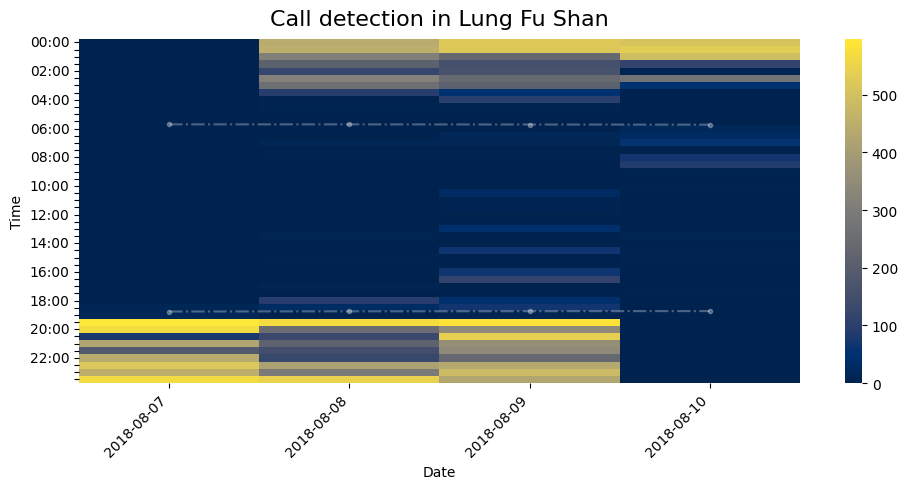

In [226]:
directory = '/Volumes/Derek/Research/Data/Acoustics/HK-LFS-20180807-20180821-SM4/HK-LFS-20180807-20180821-SM4-wav/test/Detection/BlueWhistleThrust/'
df = result_visualisation.load_data(directory, end_str='BlueWhistleThrust.DetProb.txt')
# df = load_data(directory, end_str='CommonTailorbird.DetProb.txt')
df = df[df['Probability']>0.9]
df = result_visualisation.resample_df(df, time_interval='30T')

# Get sunrise and sunset
latitude = 22.319
longitude = 114.169 
unique_dates = pd.to_datetime(df['date']).dt.date.unique() 
sun_times = result_visualisation.get_sun_times(latitude, longitude, unique_dates)

result_visualisation.plot_heatmap(df, sun_times, figsize=(10, 5), cmap='cividis', annot=False, rotation=45, every_nth=4, title='Call detection in Lung Fu Shan')

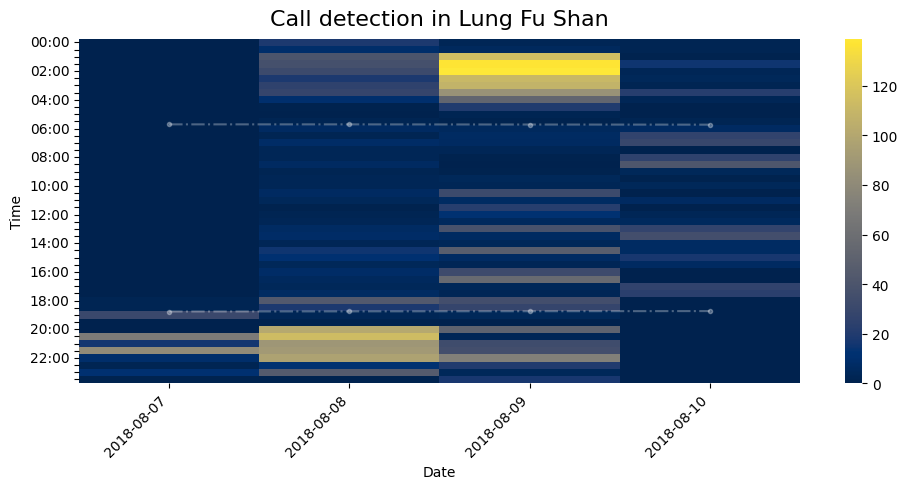

In [228]:
directory = '/Volumes/Derek/Research/Data/Acoustics/HK-LFS-20180807-20180821-SM4/HK-LFS-20180807-20180821-SM4-wav/test/Detection/BlueWhistleThrust/'
df = result_visualisation.load_data(directory, end_str='.Detection.txt')
df = result_visualisation.resample_df(df, time_interval='30T')

# Get sunrise and sunset
latitude = 22.319
longitude = 114.169 
unique_dates = pd.to_datetime(df['date']).dt.date.unique() 
sun_times = result_visualisation.get_sun_times(latitude, longitude, unique_dates)

result_visualisation.plot_heatmap(df, sun_times, figsize=(10, 5), cmap='cividis', annot=False, rotation=45, every_nth=4, title='Call detection in Lung Fu Shan')